**INITIALIZATION**

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


In [ ]:
#Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow.random import gamma as tf_random_gamma
from sklearn.utils import shuffle
from collections import Counter

#set random seed
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

**DATA INITIALIZATION**

In [ ]:
#import data from google drive
data = np.load("filteredData.npz")
print("Keys: ", data.keys())
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data['x_test']
print("Data shape: ", x_train.shape)
print("Label shape: ", y_train.shape)
print("Test shape: ", x_test.shape)

Keys:  KeysView(NpzFile 'filteredData.npz' with keys: x_train, y_train, x_test)
Data shape:  (2505, 64, 128)
Label shape:  (2505, 64, 128)
Test shape:  (10022, 64, 128)


In [ ]:
# Add color channel and rescale pixels between 0 and 1
x_train = x_train[..., np.newaxis] / 255.0
x_test = x_test[..., np.newaxis] / 255.0

input_shape = x_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
# Training data
split_size = 250
batch_size = 16
learning_rate = 1e-3
patience = 20
epochs = 200

In [ ]:
# Train validation split
train_img, val_img, train_lbl, val_lbl = train_test_split(
    x_train, y_train, test_size=split_size, random_state=seed
)

In [ ]:
from collections import Counter

num_classes = 5  # Adjust this to the actual number of classes
class_pixel_counts = np.zeros(num_classes, dtype=int)

# Iterate through all masks to calculate pixel counts per class
for mask in train_lbl:
    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        class_pixel_counts[int(u)] += c


# Calculate percentages
total_pixels = np.sum(class_pixel_counts)
class_percentages = (class_pixel_counts / total_pixels) * 100

# Display the results
print("TRAINING")
for cls, count, pct in zip(range(num_classes), class_pixel_counts, class_percentages):
    print(f"Class {cls}: {count} pixels ({pct:.2f}%)")

TRAINING
Class 0: 4514984 pixels (24.44%)
Class 1: 6260890 pixels (33.89%)
Class 2: 4331492 pixels (23.45%)
Class 3: 3339887 pixels (18.08%)
Class 4: 25707 pixels (0.14%)


In [ ]:
from collections import Counter

num_classes = 5  # Adjust this to the actual number of classes
class_pixel_counts = np.zeros(num_classes, dtype=int)

# Iterate through all masks to calculate pixel counts per class
for mask in val_lbl:
    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        class_pixel_counts[int(u)] += c


# Calculate percentages
total_pixels = np.sum(class_pixel_counts)
class_percentages = (class_pixel_counts / total_pixels) * 100

# Display the results
print("VALIDATION")
for cls, count, pct in zip(range(num_classes), class_pixel_counts, class_percentages):
    print(f"Class {cls}: {count} pixels ({pct:.2f}%)")

VALIDATION
Class 0: 473842 pixels (23.14%)
Class 1: 696648 pixels (34.02%)
Class 2: 445318 pixels (21.74%)
Class 3: 430936 pixels (21.04%)
Class 4: 1256 pixels (0.06%)


**DATA AUGMENTATION**

In [ ]:
# Flips image and mask horizontally
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [ ]:
# Flips image and mask vertically
@tf.function
def random_vertical_flip(image, label, seed=None):
    """Consistent random vertical flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label

In [ ]:
def expand_lbl(image, label):
  return image, tf.expand_dims(label, axis=-1)

In [ ]:
def reduce_lbl(image, label):
  return image, tf.squeeze(label)

In [ ]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(len(images), seed=seed)

    if augment:
        dataset = dataset.map(
            lambda x, y: expand_lbl(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: random_vertical_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: reduce_lbl(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:

# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=batch_size,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (16, 64, 128, 1)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'float64'>


**VISUAL STUFF**

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored



Visualizing examples from the training set:


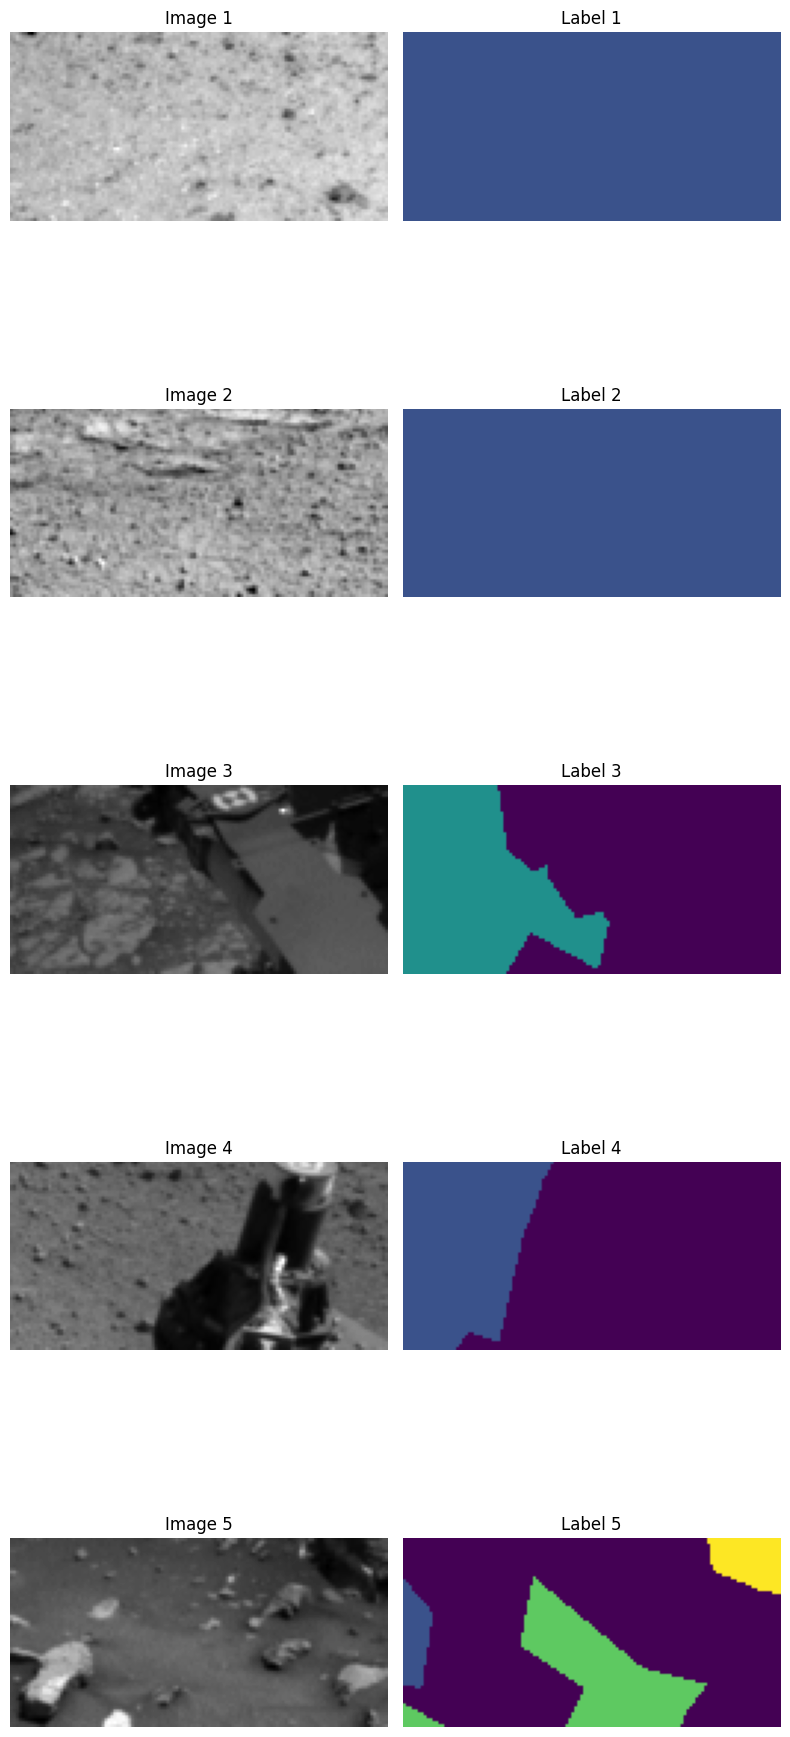

In [ ]:
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(8, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=5)

In [ ]:
# Index of the val image to visualize during training
index = 0
for idx, mask in enumerate(val_lbl):
  unique = np.unique(mask)
  if(4 in unique):
    index = idx
    break

print(index)

24


**MODEL CREATION**

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)


    # Return the transformed tensor
    return x

def squeeze_and_excitation_block(inputs, ratio=16):
  channels = inputs.shape[-1]
  squeeze = tfkl.GlobalAveragePooling2D()(inputs)
  excitation = tfkl.Dense(channels // ratio, activation='relu')(squeeze)
  excitation =tfkl.Dense(channels, activation='sigmoid')(excitation)
  excitation = tfkl.Reshape((1, 1, channels))(excitation)
  scale = tfkl.Multiply()([inputs, excitation])
  return scale

In [ ]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3= unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4= unet_block(d3, 256, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)
    # Bottleneck

    bottleneck = unet_block(d4, 512, name='bottleneck')
    #bottleneck = squeeze_and_excitation_block(bottleneck)

    # Upsampling path
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_4])
    u1 = unet_block(u1, 256, name='up_block1_')

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = unet_block(u2, 128, name='up_block2_')

    u3 =  tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 64, name='up_block3_')

    u4 =  tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 32, name='up_block4_')


    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_8        │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_8[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 7,771,429 (29.65 MB)

 Trainable params: 7,765,541 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

**LOSSES**

In [ ]:

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for multi-class classification.

    Args:
        gamma: Focusing parameter to down-weight easy examples.
        alpha: Balancing factor for class imbalance.

    Returns:
        A callable loss function to be used with tf.keras.
    """
    def loss(y_true, y_pred):
        # One-hot encode y_true if not already
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])


        # Calculate focal loss
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)  # Avoid log(0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        focal_loss = weight * cross_entropy

        # Reduce mean
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return loss

In [ ]:

def dice_loss(smooth=10e-6):
  def loss(y_true, y_pred):
      """
      Compute Dice Loss for multi-class segmentation.

      Args:
          y_true: Ground truth labels (one-hot encoded) with shape (batch_size, height, width, num_classes).
          y_pred: Predicted logits with shape (batch_size, height, width, num_classes).
          smooth: Smoothing factor to avoid division by zero.

      Returns:
          Dice loss.
      """
      y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

      # Flatten the tensors
      y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
      y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

      # Compute intersection and union
      intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
      union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)

      # Compute Dice coefficient
      dice = (2. * intersection + smooth) / (union + smooth)

      # Compute Dice loss
      return 1 - tf.reduce_mean(dice)
  return loss


In [ ]:
def focal_dice_loss(alpha=1, beta=1):
  def loss(y_true, y_pred):
    return alpha*focal_loss(y_true, y_pred) + beta*dice_loss(y_true, y_pred)
  return loss

**MODEL COMPILATION**

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


In [ ]:
# Compile the model

model.compile(
    loss=dice_loss(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate, weight_decay=0.0001),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)


**CALLBACKS**

In [ ]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

viz_callback = VizCallback(val_img[index], val_lbl[index], frequency=5)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=patience/2, min_lr=1e-6, monitor='val_accuracy')

**MODEL TRAINING**

Epoch 1/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4042 - loss: 0.7031 - mean_iou: 0.1890

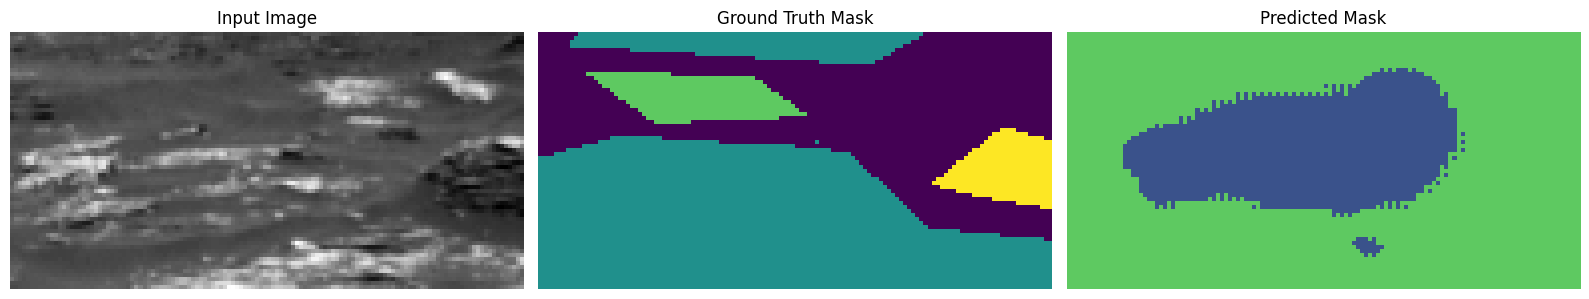

141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 173ms/step - accuracy: 0.4045 - loss: 0.7029 - mean_iou: 0.1891 - val_accuracy: 0.2554 - val_loss: 0.8697 - val_mean_iou: 0.1196 - learning_rate: 0.0010
Epoch 2/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5258 - loss: 0.5996 - mean_iou: 0.2584 - val_accuracy: 0.2106 - val_loss: 0.9312 - val_mean_iou: 0.0548 - learning_rate: 0.0010
Epoch 3/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5505 - loss: 0.5780 - mean_iou: 0.2788 - val_accuracy: 0.2753 - val_loss: 0.8489 - val_mean_iou: 0.0968 - learning_rate: 0.0010
Epoch 4/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5631 - loss: 0.5681 - mean_iou: 0.2848 - val_accuracy: 0.2969 - val_loss: 0.8190 - val_mean_iou: 0.0619 - learning_rate: 0.0010
Epoch 5/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5861 - loss: 0.5477 - mean_iou: 0.3107 - val_accuracy: 0.3829 - val_loss: 0.7410 - val_mean_iou: 0.1324 - learning_rate: 0.0010
Epoch 6/200
141/141 ━━━━━━━━━━

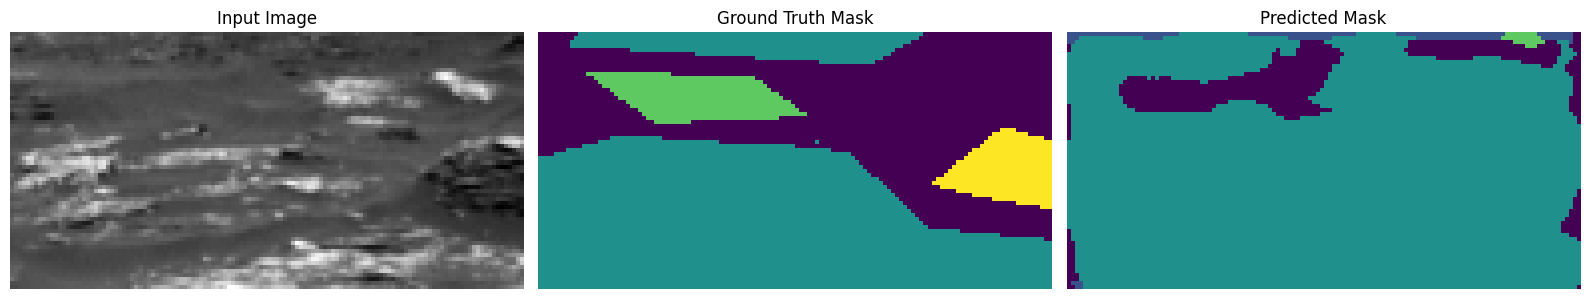

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5583 - loss: 0.5675 - mean_iou: 0.2842 - val_accuracy: 0.3729 - val_loss: 0.7593 - val_mean_iou: 0.1739 - learning_rate: 0.0010
Epoch 7/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5881 - loss: 0.5442 - mean_iou: 0.3172 - val_accuracy: 0.3718 - val_loss: 0.8111 - val_mean_iou: 0.0821 - learning_rate: 0.0010
Epoch 8/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6258 - loss: 0.5180 - mean_iou: 0.3352 - val_accuracy: 0.5143 - val_loss: 0.6081 - val_mean_iou: 0.2379 - learning_rate: 0.0010
Epoch 9/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6278 - loss: 0.5135 - mean_iou: 0.3459 - val_accuracy: 0.3725 - val_loss: 0.7654 - val_mean_iou: 0.1092 - learning_rate: 0.0010
Epoch 10/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6264 - loss: 0.5115 - mean_iou: 0.3511 - val_accuracy: 0.6201 - val_loss: 0.5306 - val_mean_iou: 0.3310 - learning_rate: 0.0010
Epoch 11/200
140/141 ━━━━━━━━━━

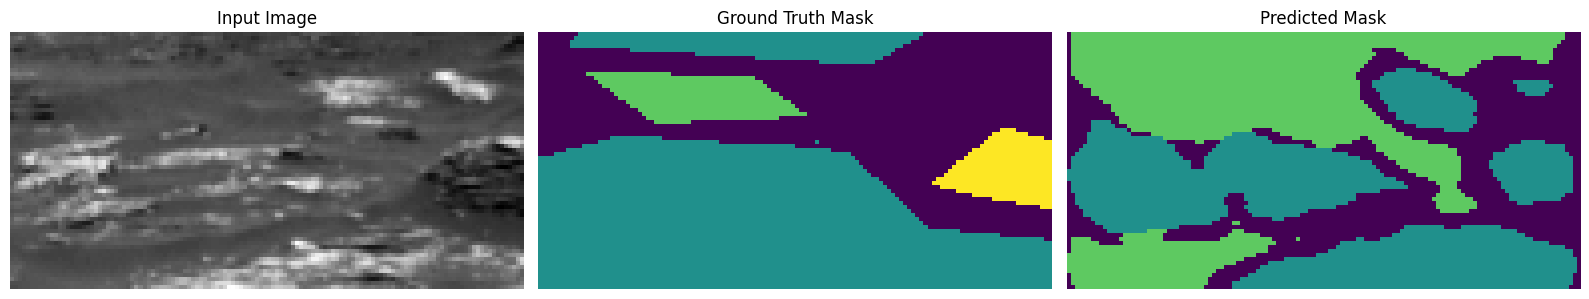

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6237 - loss: 0.5202 - mean_iou: 0.3348 - val_accuracy: 0.5970 - val_loss: 0.5535 - val_mean_iou: 0.3189 - learning_rate: 0.0010
Epoch 12/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6261 - loss: 0.5169 - mean_iou: 0.3398 - val_accuracy: 0.3277 - val_loss: 0.7943 - val_mean_iou: 0.0894 - learning_rate: 0.0010
Epoch 13/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6222 - loss: 0.5186 - mean_iou: 0.3410 - val_accuracy: 0.5606 - val_loss: 0.5701 - val_mean_iou: 0.2775 - learning_rate: 0.0010
Epoch 14/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6108 - loss: 0.5291 - mean_iou: 0.3315 - val_accuracy: 0.6487 - val_loss: 0.5120 - val_mean_iou: 0.3786 - learning_rate: 0.0010
Epoch 15/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6398 - loss: 0.5075 - mean_iou: 0.3557 - val_accuracy: 0.3845 - val_loss: 0.7355 - val_mean_iou: 0.1404 - learning_rate: 0.0010
Epoch 16/200
140/141 ━━━━━━━

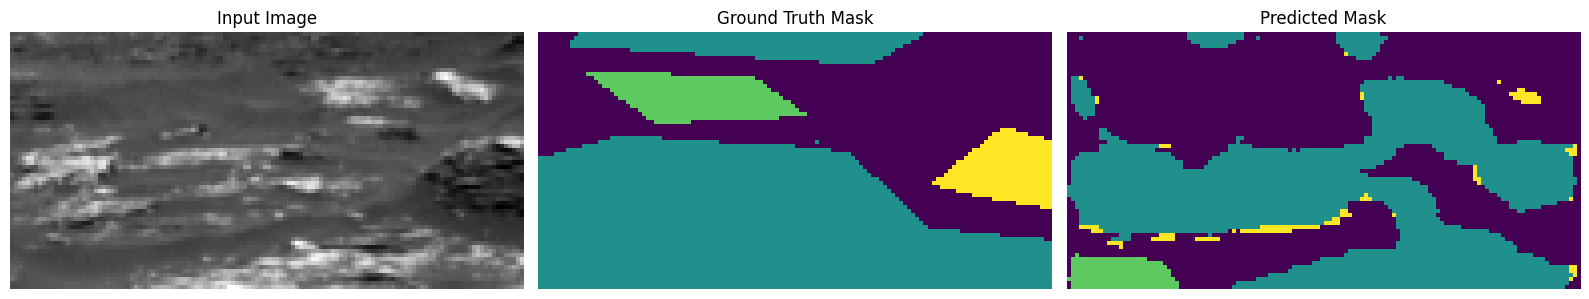

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6394 - loss: 0.5067 - mean_iou: 0.3494 - val_accuracy: 0.6394 - val_loss: 0.5172 - val_mean_iou: 0.3488 - learning_rate: 0.0010
Epoch 17/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6566 - loss: 0.4913 - mean_iou: 0.3647 - val_accuracy: 0.5347 - val_loss: 0.5836 - val_mean_iou: 0.2643 - learning_rate: 0.0010
Epoch 18/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6534 - loss: 0.4935 - mean_iou: 0.3596 - val_accuracy: 0.5947 - val_loss: 0.5754 - val_mean_iou: 0.2948 - learning_rate: 0.0010
Epoch 19/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6443 - loss: 0.4963 - mean_iou: 0.3591 - val_accuracy: 0.6807 - val_loss: 0.4738 - val_mean_iou: 0.3826 - learning_rate: 0.0010
Epoch 20/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6831 - loss: 0.4706 - mean_iou: 0.3913 - val_accuracy: 0.5433 - val_loss: 0.6161 - val_mean_iou: 0.2425 - learning_rate: 0.0010
Epoch 21/200
140/141 ━━━━━━━

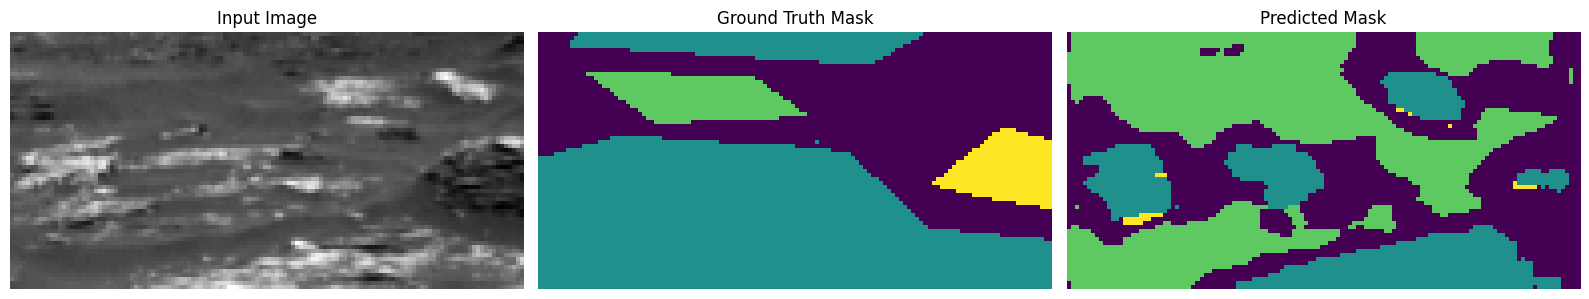

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6762 - loss: 0.4715 - mean_iou: 0.3954 - val_accuracy: 0.6989 - val_loss: 0.4638 - val_mean_iou: 0.4026 - learning_rate: 0.0010
Epoch 22/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6679 - loss: 0.4851 - mean_iou: 0.3707 - val_accuracy: 0.6528 - val_loss: 0.5180 - val_mean_iou: 0.3379 - learning_rate: 0.0010
Epoch 23/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6683 - loss: 0.4797 - mean_iou: 0.3749 - val_accuracy: 0.6260 - val_loss: 0.5158 - val_mean_iou: 0.3339 - learning_rate: 0.0010
Epoch 24/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6843 - loss: 0.4632 - mean_iou: 0.3895 - val_accuracy: 0.5445 - val_loss: 0.6223 - val_mean_iou: 0.2540 - learning_rate: 0.0010
Epoch 25/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6691 - loss: 0.4705 - mean_iou: 0.3914 - val_accuracy: 0.6232 - val_loss: 0.5079 - val_mean_iou: 0.3313 - learning_rate: 0.0010
Epoch 26/200
141/141 ━━━━━━━

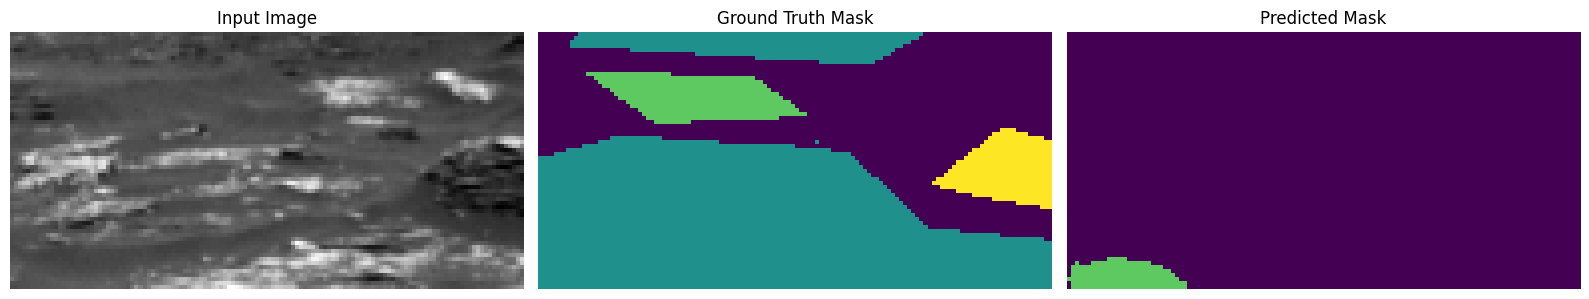

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6916 - loss: 0.4631 - mean_iou: 0.3953 - val_accuracy: 0.5059 - val_loss: 0.6637 - val_mean_iou: 0.2152 - learning_rate: 0.0010
Epoch 27/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6675 - loss: 0.4788 - mean_iou: 0.3811 - val_accuracy: 0.5937 - val_loss: 0.5983 - val_mean_iou: 0.2723 - learning_rate: 0.0010
Epoch 28/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6847 - loss: 0.4633 - mean_iou: 0.3934 - val_accuracy: 0.7045 - val_loss: 0.4534 - val_mean_iou: 0.4089 - learning_rate: 0.0010
Epoch 29/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6969 - loss: 0.4511 - mean_iou: 0.4054 - val_accuracy: 0.7130 - val_loss: 0.4499 - val_mean_iou: 0.4179 - learning_rate: 0.0010
Epoch 30/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7031 - loss: 0.4441 - mean_iou: 0.4240 - val_accuracy: 0.7168 - val_loss: 0.4377 - val_mean_iou: 0.4234 - learning_rate: 0.0010
Epoch 31/200
140/141 ━━━━━━━

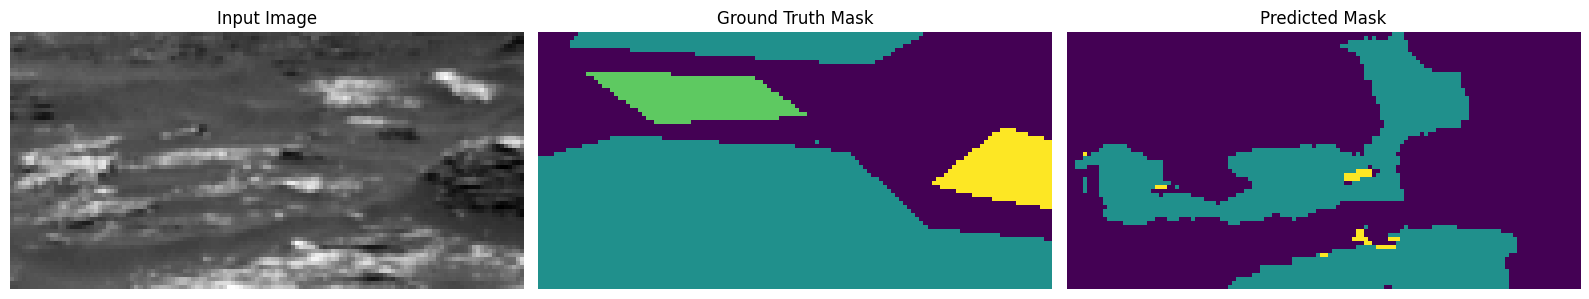

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6885 - loss: 0.4524 - mean_iou: 0.4116 - val_accuracy: 0.7075 - val_loss: 0.4444 - val_mean_iou: 0.4012 - learning_rate: 0.0010
Epoch 32/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6864 - loss: 0.4621 - mean_iou: 0.4051 - val_accuracy: 0.6981 - val_loss: 0.4575 - val_mean_iou: 0.3905 - learning_rate: 0.0010
Epoch 33/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6889 - loss: 0.4577 - mean_iou: 0.3996 - val_accuracy: 0.6185 - val_loss: 0.5589 - val_mean_iou: 0.3020 - learning_rate: 0.0010
Epoch 34/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6949 - loss: 0.4509 - mean_iou: 0.4107 - val_accuracy: 0.6274 - val_loss: 0.5323 - val_mean_iou: 0.3028 - learning_rate: 0.0010
Epoch 35/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7037 - loss: 0.4433 - mean_iou: 0.4151 - val_accuracy: 0.5938 - val_loss: 0.5836 - val_mean_iou: 0.2597 - learning_rate: 0.0010
Epoch 36/200
140/141 ━━━━━━━

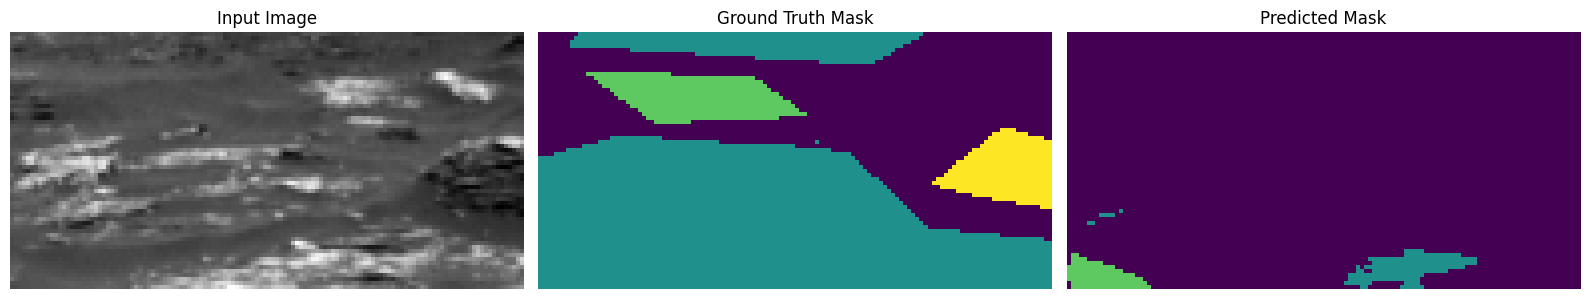

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6939 - loss: 0.4521 - mean_iou: 0.4080 - val_accuracy: 0.6232 - val_loss: 0.5513 - val_mean_iou: 0.3046 - learning_rate: 0.0010
Epoch 37/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6807 - loss: 0.4634 - mean_iou: 0.4021 - val_accuracy: 0.7025 - val_loss: 0.4559 - val_mean_iou: 0.3907 - learning_rate: 0.0010
Epoch 38/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7082 - loss: 0.4405 - mean_iou: 0.4137 - val_accuracy: 0.6983 - val_loss: 0.4571 - val_mean_iou: 0.4130 - learning_rate: 0.0010
Epoch 39/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7222 - loss: 0.4329 - mean_iou: 0.4311 - val_accuracy: 0.5783 - val_loss: 0.6030 - val_mean_iou: 0.2701 - learning_rate: 0.0010
Epoch 40/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7003 - loss: 0.4502 - mean_iou: 0.4105 - val_accuracy: 0.6700 - val_loss: 0.4831 - val_mean_iou: 0.3981 - learning_rate: 0.0010
Epoch 41/200
140/141 ━━━━━━━

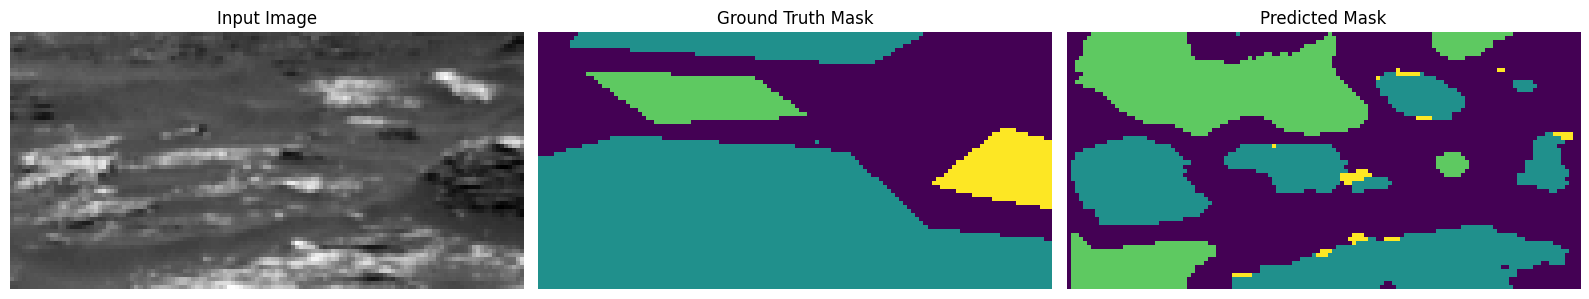

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7245 - loss: 0.4213 - mean_iou: 0.4576 - val_accuracy: 0.7427 - val_loss: 0.4226 - val_mean_iou: 0.4378 - learning_rate: 5.0000e-04
Epoch 42/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7401 - loss: 0.4104 - mean_iou: 0.4568 - val_accuracy: 0.7406 - val_loss: 0.4227 - val_mean_iou: 0.4292 - learning_rate: 5.0000e-04
Epoch 43/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7246 - loss: 0.4321 - mean_iou: 0.4397 - val_accuracy: 0.7208 - val_loss: 0.4465 - val_mean_iou: 0.4090 - learning_rate: 5.0000e-04
Epoch 44/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7218 - loss: 0.4342 - mean_iou: 0.4272 - val_accuracy: 0.7373 - val_loss: 0.4287 - val_mean_iou: 0.4372 - learning_rate: 5.0000e-04
Epoch 45/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7249 - loss: 0.4294 - mean_iou: 0.4344 - val_accuracy: 0.7446 - val_loss: 0.4219 - val_mean_iou: 0.4415 - learning_rate: 5.0000e-04
Epoch 46

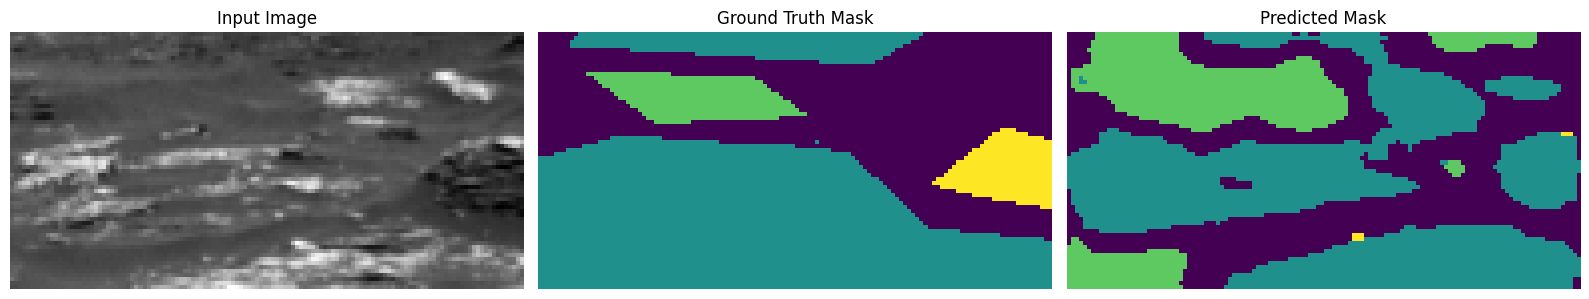

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7359 - loss: 0.4163 - mean_iou: 0.4620 - val_accuracy: 0.7251 - val_loss: 0.4463 - val_mean_iou: 0.4477 - learning_rate: 5.0000e-04
Epoch 47/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7280 - loss: 0.4296 - mean_iou: 0.4389 - val_accuracy: 0.7395 - val_loss: 0.4178 - val_mean_iou: 0.4378 - learning_rate: 5.0000e-04
Epoch 48/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7524 - loss: 0.3976 - mean_iou: 0.4726 - val_accuracy: 0.7386 - val_loss: 0.4315 - val_mean_iou: 0.4371 - learning_rate: 5.0000e-04
Epoch 49/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7447 - loss: 0.4118 - mean_iou: 0.4524 - val_accuracy: 0.7289 - val_loss: 0.4301 - val_mean_iou: 0.4183 - learning_rate: 5.0000e-04
Epoch 50/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7376 - loss: 0.4191 - mean_iou: 0.4456 - val_accuracy: 0.7197 - val_loss: 0.4406 - val_mean_iou: 0.4269 - learning_rate: 5.0000e-04
Epoch 51

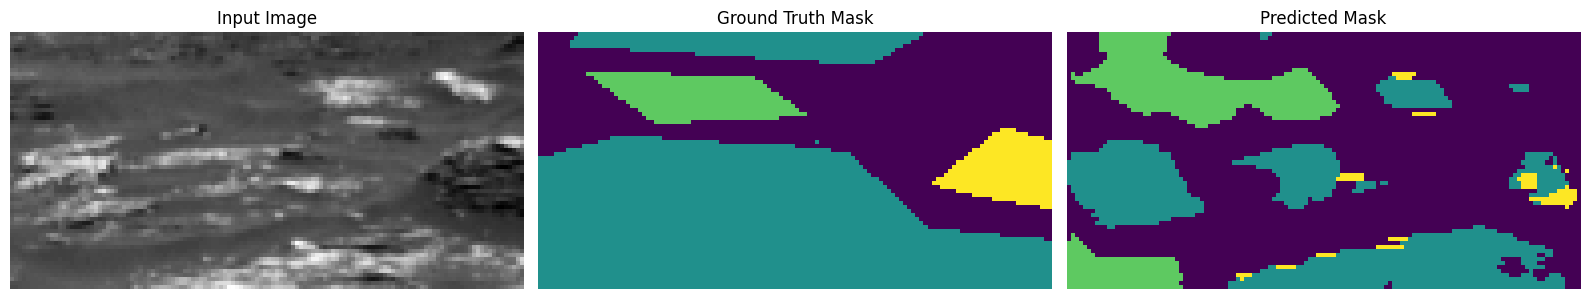

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.7319 - loss: 0.4270 - mean_iou: 0.4432 - val_accuracy: 0.7406 - val_loss: 0.4208 - val_mean_iou: 0.4264 - learning_rate: 5.0000e-04
Epoch 52/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7450 - loss: 0.4130 - mean_iou: 0.4610 - val_accuracy: 0.7479 - val_loss: 0.4187 - val_mean_iou: 0.4534 - learning_rate: 5.0000e-04
Epoch 53/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7371 - loss: 0.4214 - mean_iou: 0.4586 - val_accuracy: 0.7246 - val_loss: 0.4362 - val_mean_iou: 0.4154 - learning_rate: 5.0000e-04
Epoch 54/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7452 - loss: 0.4135 - mean_iou: 0.4539 - val_accuracy: 0.7362 - val_loss: 0.4327 - val_mean_iou: 0.4317 - learning_rate: 5.0000e-04
Epoch 55/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7473 - loss: 0.3979 - mean_iou: 0.4629 - val_accuracy: 0.7206 - val_loss: 0.4448 - val_mean_iou: 0.4057 - learning_rate: 5.0000e-04
Epoch 56

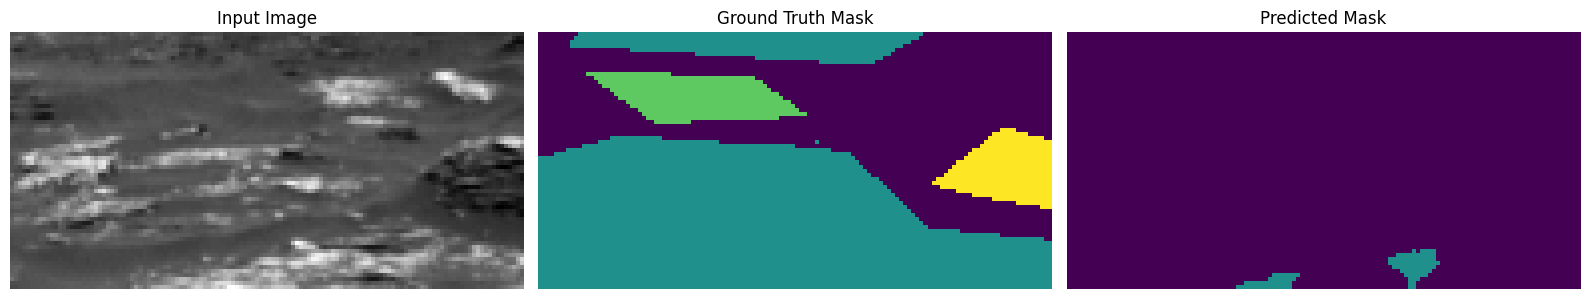

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7442 - loss: 0.4069 - mean_iou: 0.4623 - val_accuracy: 0.6718 - val_loss: 0.4785 - val_mean_iou: 0.3583 - learning_rate: 5.0000e-04
Epoch 57/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7434 - loss: 0.4113 - mean_iou: 0.4611 - val_accuracy: 0.7248 - val_loss: 0.4322 - val_mean_iou: 0.4212 - learning_rate: 5.0000e-04
Epoch 58/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7401 - loss: 0.4190 - mean_iou: 0.4516 - val_accuracy: 0.7375 - val_loss: 0.4299 - val_mean_iou: 0.4225 - learning_rate: 5.0000e-04
Epoch 59/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7559 - loss: 0.4046 - mean_iou: 0.4664 - val_accuracy: 0.7613 - val_loss: 0.4072 - val_mean_iou: 0.4547 - learning_rate: 5.0000e-04
Epoch 60/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7403 - loss: 0.4134 - mean_iou: 0.4619 - val_accuracy: 0.7623 - val_loss: 0.4070 - val_mean_iou: 0.4606 - learning_rate: 5.0000e-04
Epoch 61

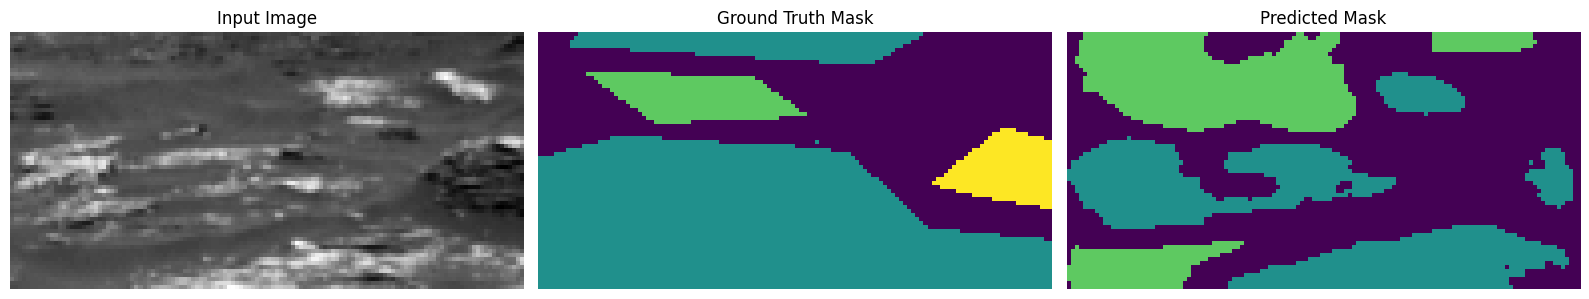

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7564 - loss: 0.3986 - mean_iou: 0.4807 - val_accuracy: 0.7558 - val_loss: 0.4117 - val_mean_iou: 0.4406 - learning_rate: 5.0000e-04
Epoch 62/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7464 - loss: 0.4063 - mean_iou: 0.4766 - val_accuracy: 0.7540 - val_loss: 0.4124 - val_mean_iou: 0.4482 - learning_rate: 5.0000e-04
Epoch 63/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7597 - loss: 0.4016 - mean_iou: 0.4761 - val_accuracy: 0.7462 - val_loss: 0.4194 - val_mean_iou: 0.4353 - learning_rate: 5.0000e-04
Epoch 64/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7602 - loss: 0.3920 - mean_iou: 0.4917 - val_accuracy: 0.7219 - val_loss: 0.4478 - val_mean_iou: 0.4222 - learning_rate: 5.0000e-04
Epoch 65/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7571 - loss: 0.4008 - mean_iou: 0.4796 - val_accuracy: 0.7390 - val_loss: 0.4247 - val_mean_iou: 0.4306 - learning_rate: 5.0000e-04
Epoch 66

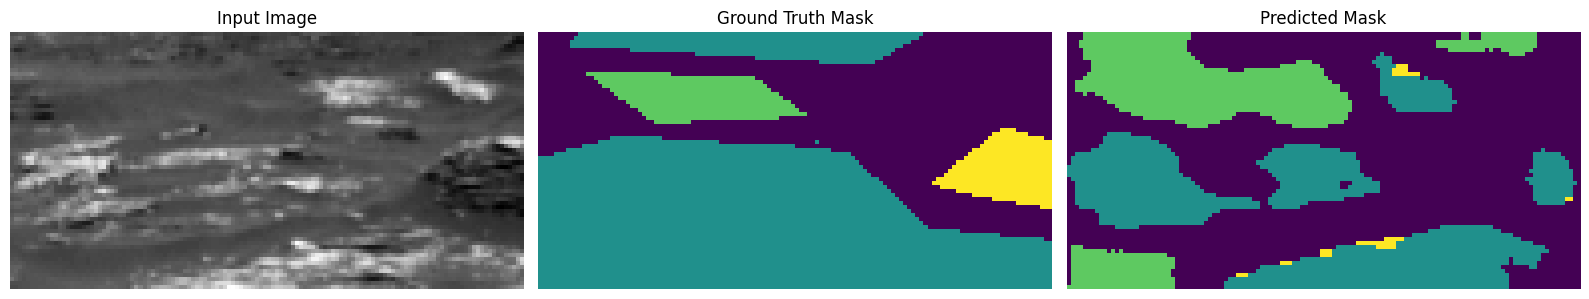

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7527 - loss: 0.4020 - mean_iou: 0.4649 - val_accuracy: 0.7378 - val_loss: 0.4309 - val_mean_iou: 0.4239 - learning_rate: 5.0000e-04
Epoch 67/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7562 - loss: 0.3987 - mean_iou: 0.4946 - val_accuracy: 0.7629 - val_loss: 0.4060 - val_mean_iou: 0.4596 - learning_rate: 5.0000e-04
Epoch 68/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7573 - loss: 0.3997 - mean_iou: 0.4760 - val_accuracy: 0.7675 - val_loss: 0.4028 - val_mean_iou: 0.4687 - learning_rate: 5.0000e-04
Epoch 69/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7651 - loss: 0.3872 - mean_iou: 0.4910 - val_accuracy: 0.7438 - val_loss: 0.4199 - val_mean_iou: 0.4362 - learning_rate: 5.0000e-04
Epoch 70/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7636 - loss: 0.3975 - mean_iou: 0.4808 - val_accuracy: 0.7621 - val_loss: 0.4114 - val_mean_iou: 0.4685 - learning_rate: 5.0000e-04
Epoch 71

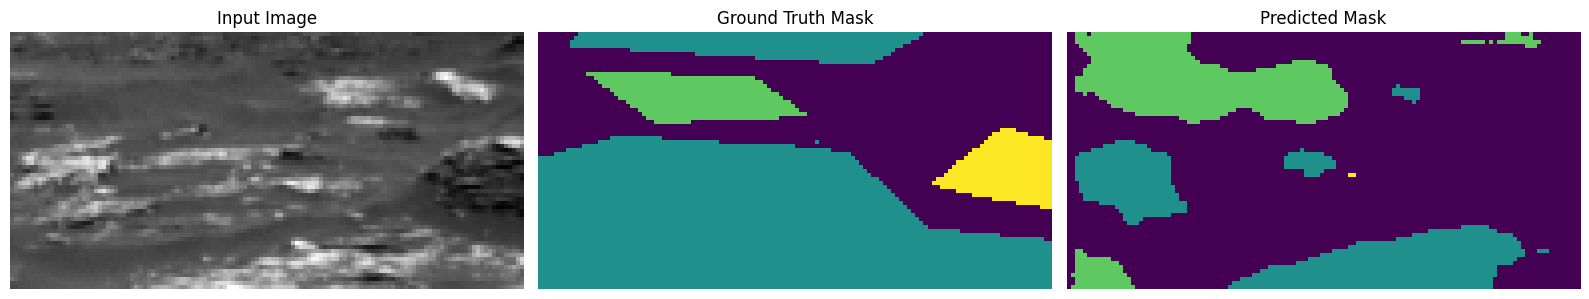

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7421 - loss: 0.4037 - mean_iou: 0.4668 - val_accuracy: 0.7299 - val_loss: 0.4331 - val_mean_iou: 0.4215 - learning_rate: 5.0000e-04
Epoch 72/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7651 - loss: 0.3951 - mean_iou: 0.4699 - val_accuracy: 0.7520 - val_loss: 0.4146 - val_mean_iou: 0.4565 - learning_rate: 5.0000e-04
Epoch 73/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7615 - loss: 0.3856 - mean_iou: 0.4989 - val_accuracy: 0.7491 - val_loss: 0.4205 - val_mean_iou: 0.4430 - learning_rate: 5.0000e-04
Epoch 74/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7626 - loss: 0.3943 - mean_iou: 0.4817 - val_accuracy: 0.7494 - val_loss: 0.4124 - val_mean_iou: 0.4433 - learning_rate: 5.0000e-04
Epoch 75/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7736 - loss: 0.3854 - mean_iou: 0.4851 - val_accuracy: 0.7505 - val_loss: 0.4162 - val_mean_iou: 0.4476 - learning_rate: 5.0000e-04
Epoch 76

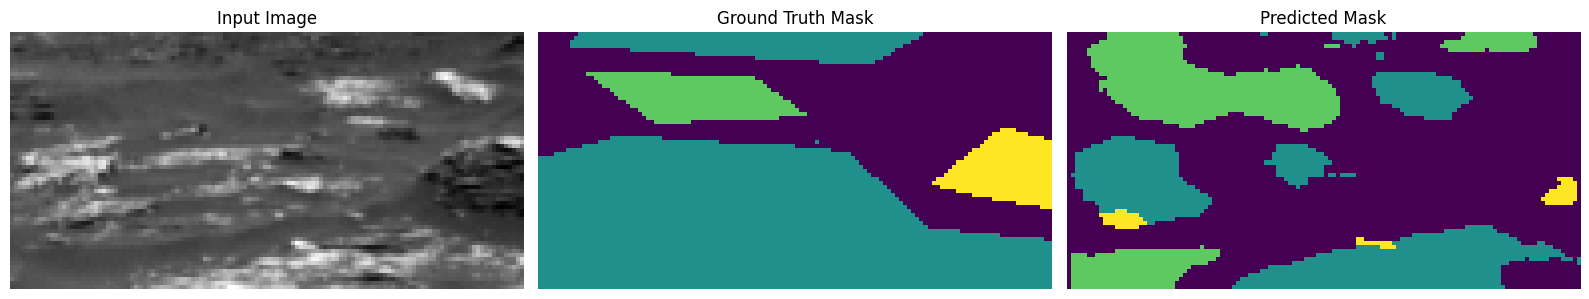

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7718 - loss: 0.3844 - mean_iou: 0.4874 - val_accuracy: 0.7207 - val_loss: 0.4381 - val_mean_iou: 0.4060 - learning_rate: 5.0000e-04
Epoch 77/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7710 - loss: 0.3843 - mean_iou: 0.5007 - val_accuracy: 0.7496 - val_loss: 0.4190 - val_mean_iou: 0.4323 - learning_rate: 5.0000e-04
Epoch 78/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7792 - loss: 0.3797 - mean_iou: 0.4908 - val_accuracy: 0.7805 - val_loss: 0.3940 - val_mean_iou: 0.4750 - learning_rate: 5.0000e-04
Epoch 79/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7789 - loss: 0.3818 - mean_iou: 0.4933 - val_accuracy: 0.7060 - val_loss: 0.4583 - val_mean_iou: 0.3920 - learning_rate: 5.0000e-04
Epoch 80/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7746 - loss: 0.3861 - mean_iou: 0.4931 - val_accuracy: 0.7454 - val_loss: 0.4307 - val_mean_iou: 0.4705 - learning_rate: 5.0000e-04
Epoch 81

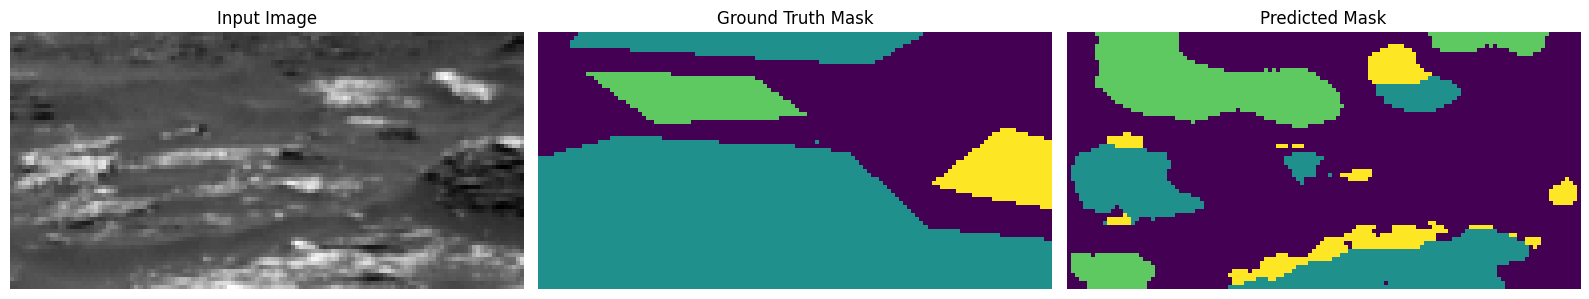

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7681 - loss: 0.3940 - mean_iou: 0.4742 - val_accuracy: 0.7280 - val_loss: 0.4353 - val_mean_iou: 0.4171 - learning_rate: 5.0000e-04
Epoch 82/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7842 - loss: 0.3785 - mean_iou: 0.5005 - val_accuracy: 0.7644 - val_loss: 0.4070 - val_mean_iou: 0.4560 - learning_rate: 5.0000e-04
Epoch 83/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7909 - loss: 0.3707 - mean_iou: 0.5094 - val_accuracy: 0.7626 - val_loss: 0.4060 - val_mean_iou: 0.4661 - learning_rate: 5.0000e-04
Epoch 84/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7717 - loss: 0.3818 - mean_iou: 0.5084 - val_accuracy: 0.7559 - val_loss: 0.4063 - val_mean_iou: 0.4517 - learning_rate: 5.0000e-04
Epoch 85/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7728 - loss: 0.3854 - mean_iou: 0.4918 - val_accuracy: 0.7330 - val_loss: 0.4288 - val_mean_iou: 0.4160 - learning_rate: 5.0000e-04
Epoch 86

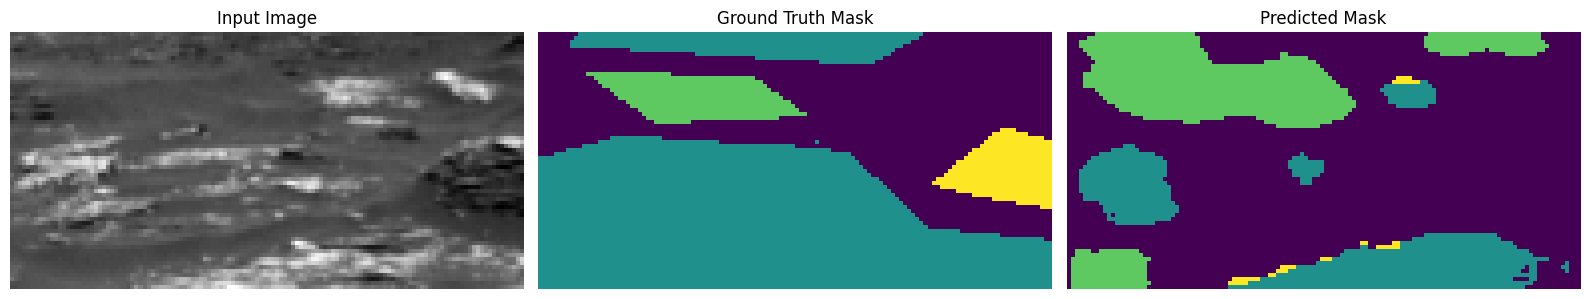

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7692 - loss: 0.3873 - mean_iou: 0.4759 - val_accuracy: 0.7075 - val_loss: 0.4611 - val_mean_iou: 0.4047 - learning_rate: 5.0000e-04
Epoch 87/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7722 - loss: 0.3829 - mean_iou: 0.4970 - val_accuracy: 0.7750 - val_loss: 0.3969 - val_mean_iou: 0.4777 - learning_rate: 5.0000e-04
Epoch 88/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7801 - loss: 0.3795 - mean_iou: 0.5018 - val_accuracy: 0.7941 - val_loss: 0.3849 - val_mean_iou: 0.4982 - learning_rate: 5.0000e-04
Epoch 89/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7850 - loss: 0.3728 - mean_iou: 0.4964 - val_accuracy: 0.7227 - val_loss: 0.4463 - val_mean_iou: 0.4024 - learning_rate: 5.0000e-04
Epoch 90/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7604 - loss: 0.3946 - mean_iou: 0.4911 - val_accuracy: 0.7475 - val_loss: 0.4134 - val_mean_iou: 0.4368 - learning_rate: 5.0000e-04
Epoch 91

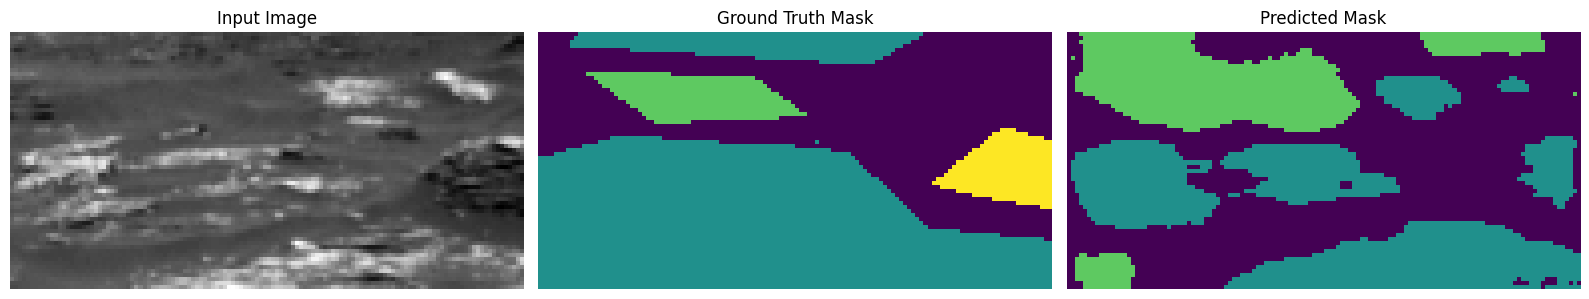

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7803 - loss: 0.3878 - mean_iou: 0.5023 - val_accuracy: 0.7363 - val_loss: 0.4279 - val_mean_iou: 0.4326 - learning_rate: 5.0000e-04
Epoch 92/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7851 - loss: 0.3786 - mean_iou: 0.4996 - val_accuracy: 0.6546 - val_loss: 0.5027 - val_mean_iou: 0.3397 - learning_rate: 5.0000e-04
Epoch 93/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7748 - loss: 0.3821 - mean_iou: 0.5197 - val_accuracy: 0.7346 - val_loss: 0.4333 - val_mean_iou: 0.4283 - learning_rate: 5.0000e-04
Epoch 94/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7920 - loss: 0.3611 - mean_iou: 0.5234 - val_accuracy: 0.7704 - val_loss: 0.3983 - val_mean_iou: 0.4629 - learning_rate: 5.0000e-04
Epoch 95/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7874 - loss: 0.3702 - mean_iou: 0.5137 - val_accuracy: 0.7738 - val_loss: 0.3947 - val_mean_iou: 0.4773 - learning_rate: 5.0000e-04
Epoch 96

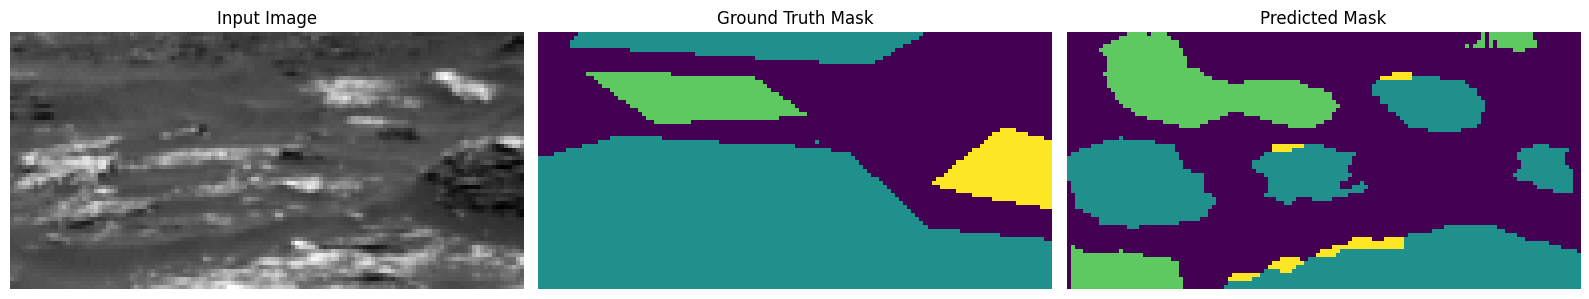

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7703 - loss: 0.3843 - mean_iou: 0.4966 - val_accuracy: 0.7665 - val_loss: 0.4026 - val_mean_iou: 0.4558 - learning_rate: 5.0000e-04
Epoch 97/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7798 - loss: 0.3782 - mean_iou: 0.4917 - val_accuracy: 0.7683 - val_loss: 0.4006 - val_mean_iou: 0.4645 - learning_rate: 5.0000e-04
Epoch 98/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7965 - loss: 0.3624 - mean_iou: 0.5121 - val_accuracy: 0.7446 - val_loss: 0.4216 - val_mean_iou: 0.4311 - learning_rate: 5.0000e-04
Epoch 99/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7870 - loss: 0.3701 - mean_iou: 0.5200 - val_accuracy: 0.7778 - val_loss: 0.3941 - val_mean_iou: 0.4776 - learning_rate: 2.5000e-04
Epoch 100/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8005 - loss: 0.3536 - mean_iou: 0.5333 - val_accuracy: 0.7931 - val_loss: 0.3835 - val_mean_iou: 0.4979 - learning_rate: 2.5000e-04
Epoch 1

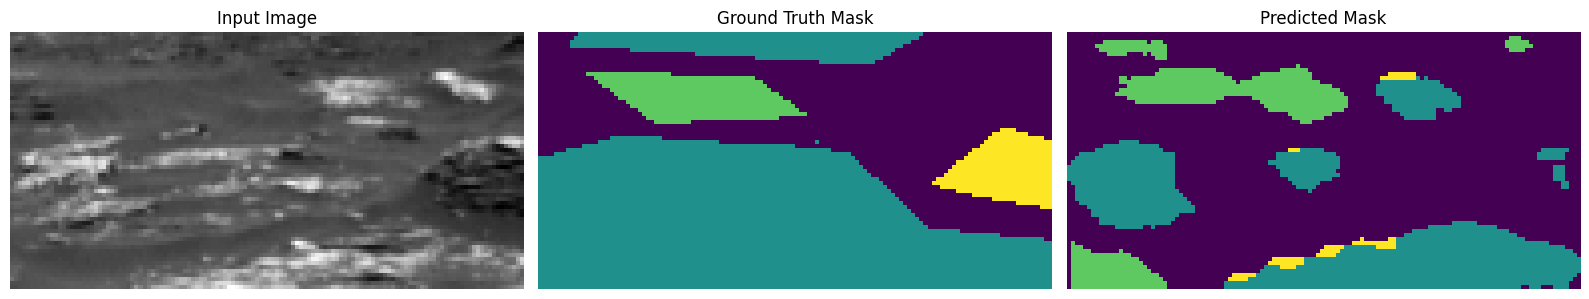

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8001 - loss: 0.3508 - mean_iou: 0.5598 - val_accuracy: 0.7652 - val_loss: 0.4067 - val_mean_iou: 0.4593 - learning_rate: 2.5000e-04
Epoch 102/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8043 - loss: 0.3545 - mean_iou: 0.5268 - val_accuracy: 0.7818 - val_loss: 0.3914 - val_mean_iou: 0.4737 - learning_rate: 2.5000e-04
Epoch 103/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8066 - loss: 0.3492 - mean_iou: 0.5532 - val_accuracy: 0.7673 - val_loss: 0.4007 - val_mean_iou: 0.4709 - learning_rate: 2.5000e-04
Epoch 104/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7990 - loss: 0.3554 - mean_iou: 0.5412 - val_accuracy: 0.7805 - val_loss: 0.3895 - val_mean_iou: 0.4751 - learning_rate: 2.5000e-04
Epoch 105/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7972 - loss: 0.3553 - mean_iou: 0.5454 - val_accuracy: 0.7688 - val_loss: 0.4026 - val_mean_iou: 0.4588 - learning_rate: 2.5000e-04
Epoc

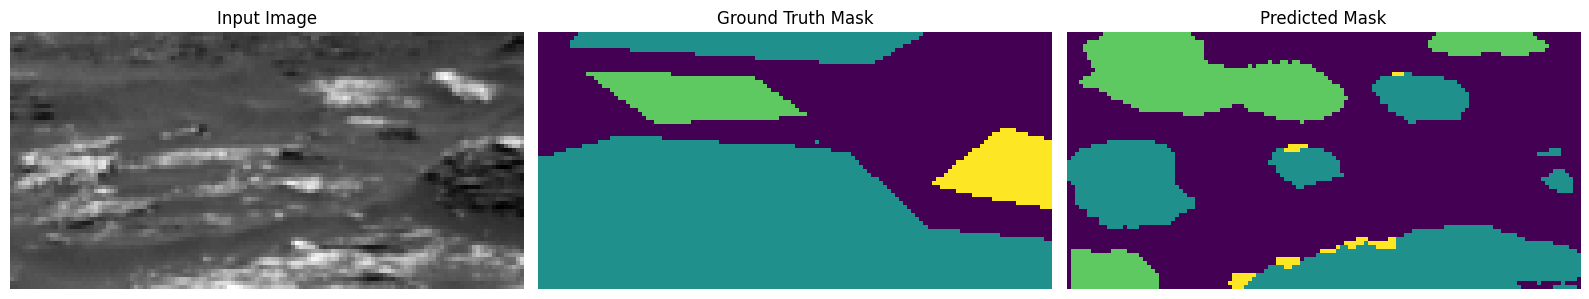

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8138 - loss: 0.3444 - mean_iou: 0.5451 - val_accuracy: 0.7788 - val_loss: 0.3901 - val_mean_iou: 0.4892 - learning_rate: 2.5000e-04
Epoch 107/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8073 - loss: 0.3399 - mean_iou: 0.5588 - val_accuracy: 0.7842 - val_loss: 0.3876 - val_mean_iou: 0.4905 - learning_rate: 2.5000e-04
Epoch 108/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8172 - loss: 0.3395 - mean_iou: 0.5561 - val_accuracy: 0.7972 - val_loss: 0.3778 - val_mean_iou: 0.5050 - learning_rate: 2.5000e-04
Epoch 109/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8076 - loss: 0.3433 - mean_iou: 0.5516 - val_accuracy: 0.7847 - val_loss: 0.3919 - val_mean_iou: 0.4940 - learning_rate: 2.5000e-04
Epoch 110/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8051 - loss: 0.3467 - mean_iou: 0.5621 - val_accuracy: 0.7857 - val_loss: 0.3877 - val_mean_iou: 0.4791 - learning_rate: 2.5000e-04
Epoc

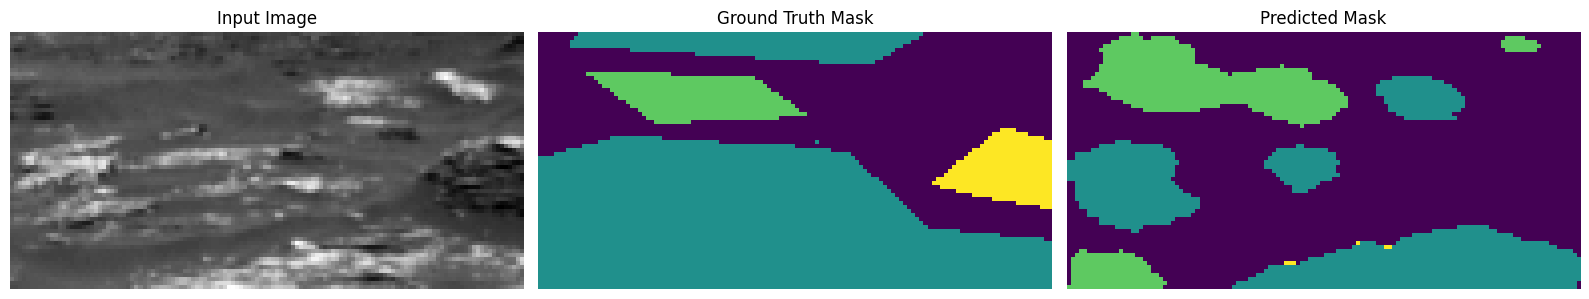

141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8043 - loss: 0.3385 - mean_iou: 0.5564 - val_accuracy: 0.7903 - val_loss: 0.3817 - val_mean_iou: 0.4889 - learning_rate: 2.5000e-04
Epoch 112/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8235 - loss: 0.3429 - mean_iou: 0.5586 - val_accuracy: 0.7850 - val_loss: 0.3890 - val_mean_iou: 0.4852 - learning_rate: 2.5000e-04
Epoch 113/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8117 - loss: 0.3413 - mean_iou: 0.5744 - val_accuracy: 0.7846 - val_loss: 0.3912 - val_mean_iou: 0.4748 - learning_rate: 2.5000e-04
Epoch 114/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8124 - loss: 0.3531 - mean_iou: 0.5664 - val_accuracy: 0.7757 - val_loss: 0.3979 - val_mean_iou: 0.4743 - learning_rate: 2.5000e-04
Epoch 115/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8151 - loss: 0.3407 - mean_iou: 0.5533 - val_accuracy: 0.7785 - val_loss: 0.3901 - val_mean_iou: 0.4840 - learning_rate: 2.5000e-04
Epoc

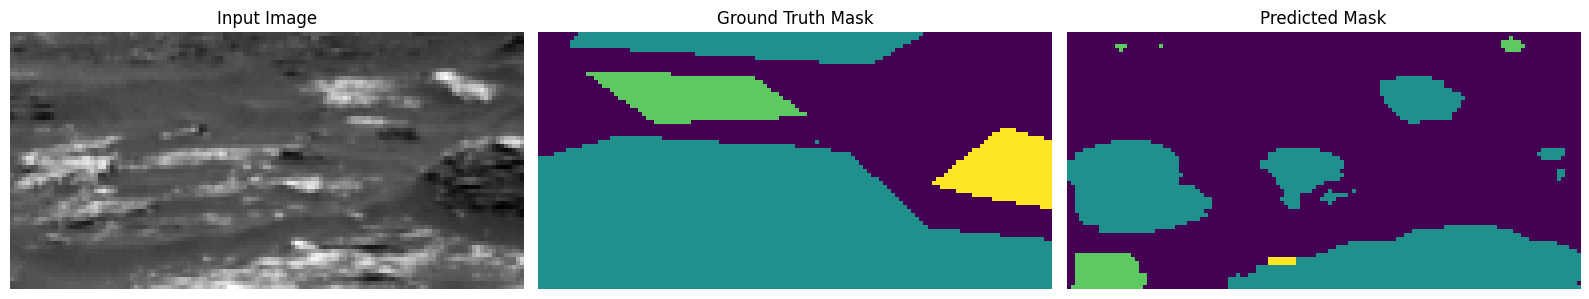

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8150 - loss: 0.3394 - mean_iou: 0.5535 - val_accuracy: 0.7749 - val_loss: 0.3934 - val_mean_iou: 0.4815 - learning_rate: 2.5000e-04
Epoch 117/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8213 - loss: 0.3377 - mean_iou: 0.5534 - val_accuracy: 0.7754 - val_loss: 0.3947 - val_mean_iou: 0.4735 - learning_rate: 2.5000e-04
Epoch 118/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8099 - loss: 0.3440 - mean_iou: 0.5537 - val_accuracy: 0.7887 - val_loss: 0.3884 - val_mean_iou: 0.4932 - learning_rate: 2.5000e-04
Epoch 119/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8205 - loss: 0.3398 - mean_iou: 0.5609 - val_accuracy: 0.7778 - val_loss: 0.3947 - val_mean_iou: 0.4727 - learning_rate: 1.2500e-04
Epoch 120/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8181 - loss: 0.3394 - mean_iou: 0.5850 - val_accuracy: 0.7864 - val_loss: 0.3876 - val_mean_iou: 0.4881 - learning_rate: 1.2500e-04
Epoc

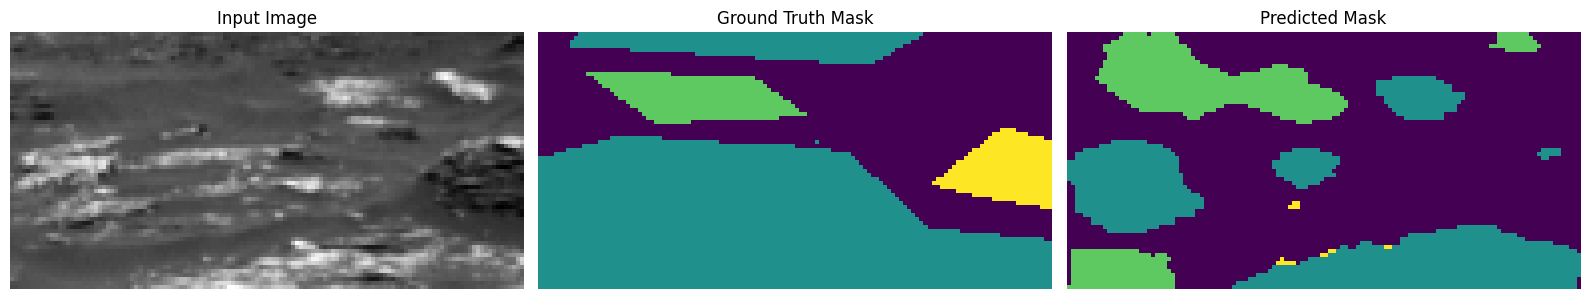

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8135 - loss: 0.3398 - mean_iou: 0.5667 - val_accuracy: 0.7845 - val_loss: 0.3895 - val_mean_iou: 0.4714 - learning_rate: 1.2500e-04
Epoch 122/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8196 - loss: 0.3303 - mean_iou: 0.5785 - val_accuracy: 0.7858 - val_loss: 0.3874 - val_mean_iou: 0.4767 - learning_rate: 1.2500e-04
Epoch 123/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8159 - loss: 0.3442 - mean_iou: 0.5435 - val_accuracy: 0.7845 - val_loss: 0.3887 - val_mean_iou: 0.4870 - learning_rate: 1.2500e-04
Epoch 124/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8158 - loss: 0.3415 - mean_iou: 0.5613 - val_accuracy: 0.7910 - val_loss: 0.3848 - val_mean_iou: 0.4855 - learning_rate: 1.2500e-04
Epoch 125/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8242 - loss: 0.3337 - mean_iou: 0.5685 - val_accuracy: 0.7860 - val_loss: 0.3876 - val_mean_iou: 0.4865 - learning_rate: 1.2500e-04
Epoc

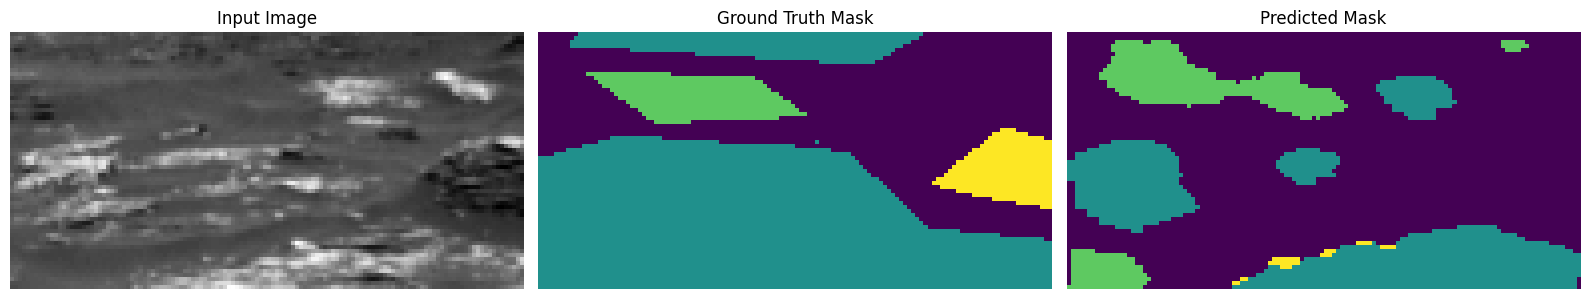

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8244 - loss: 0.3403 - mean_iou: 0.5770 - val_accuracy: 0.7907 - val_loss: 0.3841 - val_mean_iou: 0.4824 - learning_rate: 1.2500e-04
Epoch 127/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8150 - loss: 0.3494 - mean_iou: 0.5550 - val_accuracy: 0.7927 - val_loss: 0.3814 - val_mean_iou: 0.4931 - learning_rate: 1.2500e-04
Epoch 128/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8269 - loss: 0.3202 - mean_iou: 0.5986 - val_accuracy: 0.7888 - val_loss: 0.3864 - val_mean_iou: 0.4899 - learning_rate: 1.2500e-04
Final validation Mean Intersection Over Union: 50.5%


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, lr_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

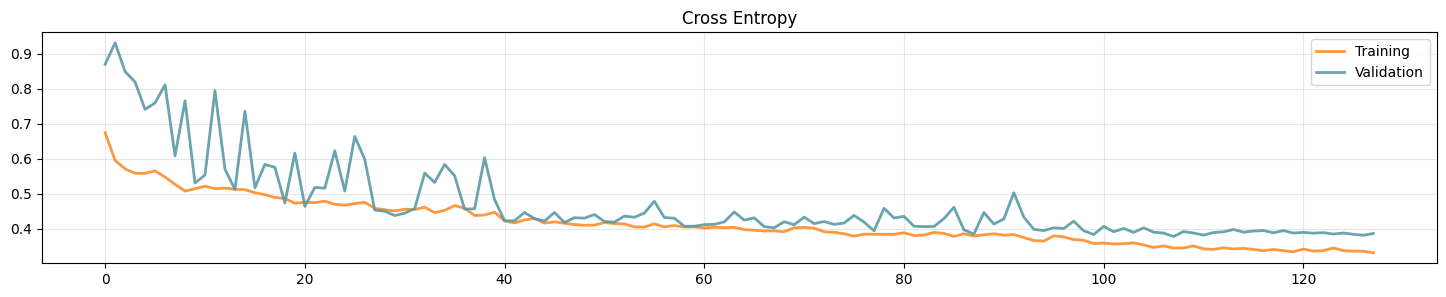

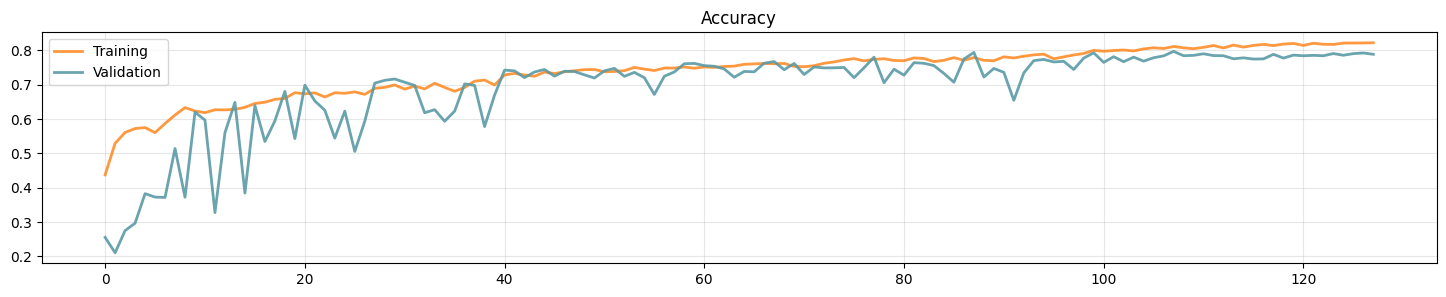

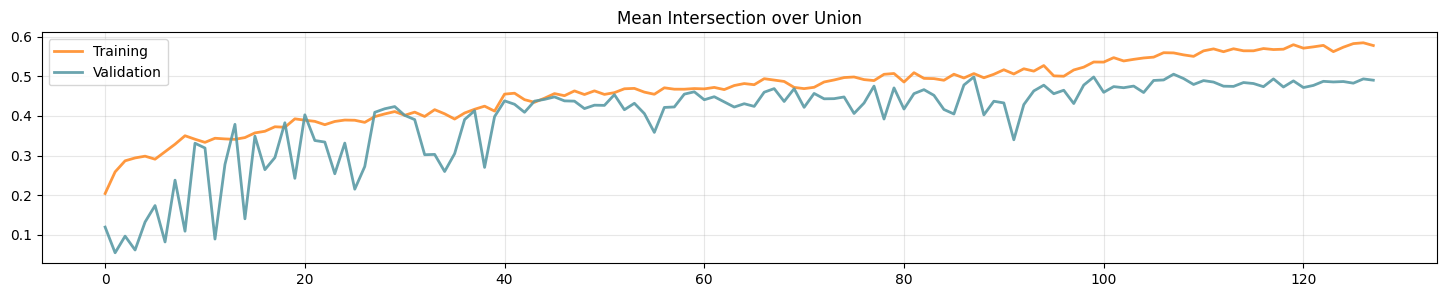

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**MODEL PERFORMANCES**

In [ ]:
model_filename = 'UNet_50.5.keras'

In [ ]:
# Load UNet model without compiling
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)


In [ ]:
# Evaluate the model on the test set and print the results
preds = model.predict(val_img, verbose=0, batch_size=10)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")
del model

Predictions shape: (250, 64, 128)


In [ ]:
def per_class_iou(y_true, y_pred, num_classes=5):
    y_true = tf.cast(y_true, tf.int32)

    ious = []
    for i in range(num_classes):
        y_true_class = tf.cast(tf.equal(y_true, i), tf.float32)
        y_pred_class = tf.cast(tf.equal(y_pred, i), tf.float32)

        intersection = tf.reduce_sum(y_true_class * y_pred_class)
        union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class) - intersection

        iou = tf.math.divide_no_nan(intersection, union)
        ious.append(iou)

    return ious

In [ ]:
ious = per_class_iou(val_lbl, preds)

In [ ]:
for idx, iou in enumerate(np.array(ious)):
  print('class '+ str(idx) + ' has an IOU of ' + str(iou) + "\n")

class 0 has an IOU of 0.45842186

class 1 has an IOU of 0.76506114

class 2 has an IOU of 0.65756327

class 3 has an IOU of 0.76579005

class 4 has an IOU of 0.052666083



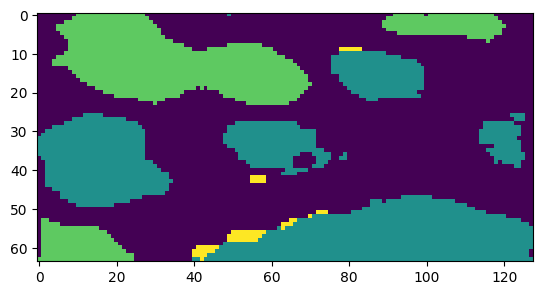

In [ ]:
colormap = create_segmentation_colormap(num_classes)
plt.imshow(apply_colormap(preds[index], colormap))

**CREATE SUBMISSION**

In [ ]:
# Load UNet model without compiling
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)


In [ ]:
# Evaluate the model on the test set and print the results
y_test = model.predict(x_test, verbose=0, batch_size=10)
preds = np.argmax(y_test, axis=-1)
print(f"Predictions shape: {preds.shape}")
del model

Predictions shape: (10022, 64, 128)


In [ ]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>